### Potential Analysis with Multiple Parameters

This notebook make applies potential analysis to the OBB measures, fitting a quartic potential, extracting the constants and generating the plots showed in the *Results* section in the paper.

A brief summary of the organization of this notebook:

### Summary

- [1 - Packages and imports](#1)

- [2 - Load data and define constants](#2)

- [3 - Potential analysis](#3)

<a name='1'></a> 
### 1. Packages and imports

In [325]:
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.optimize import curve_fit
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
plt.rcParams.update({'font.size': 15})

<a name='2'></a> 
### 2. Load data and define constants

The data loaded will be `.csv` file from the one hour video and from the simulations for the OBB that was executed considering the $NA$ of $0.46$, the best value encountered according to the Kullback-Leibler method. The simulation will be loaded and then translated to have zero mean, a variable $r$ will be created considering the values of $x$ and $y$.

In [78]:
kb = 1.380649*(10**-23)
T = 300

In [80]:
folder = '../data/simulations/obb_nas'
x = np.loadtxt(f'{folder}/OBB_simulation_positions_x0.46_1.txt', delimiter=',')
y = np.loadtxt(f'{folder}/OBB_simulation_positions_y0.46_1.txt', delimiter=',')
z = np.loadtxt(f'{folder}/OBB_simulation_positions_z0.46_1.txt', delimiter=',')
x = x - x.mean()
y = y - y.mean()
z = z - z.mean()
r = np.sqrt(np.power(x, 2)+np.power(y, 2))

In [125]:
measures = pd.read_csv('../data/dataframes/filtered/hour.csv')
measures['z'] = measures['z'].values - measures['z'].values.mean()
measures['r'] = np.sqrt(np.power(measures['x-um'].values,2)+np.power(measures['y-um'].values,2))
rmse_z = np.sqrt(np.power(z,2).mean())
rmse_measure_z = np.sqrt(np.power(measures['z'].values, 2).mean())
measures['z-scaled'] = conv_z*measures['z']
conv_z = rmse_z/rmse_measure_z

In [126]:
measures.head()

,filename,radius,z,index,x-um,y-um,r,z-scaled
0,frame46006.jpg,19.235483,-2.364381,46006,8.468811e-09,1.756195e-08,1.949725e-08,-8.205147e-08
1,frame20383.jpg,18.836752,1.517499,20383,-6.497804e-09,1.765377e-08,1.881162e-08,5.266198e-08
2,frame49335.jpg,18.309128,0.686878,49335,-3.161867e-09,-2.705666e-08,2.724078e-08,2.383685e-08
3,frame10240.jpg,17.793230,-0.139629,10240,-5.420442e-09,-1.591671e-08,1.681437e-08,-4.845577e-09
4,frame56215.jpg,18.137596,-1.258068,56215,7.311082e-09,2.798151e-08,2.892087e-08,-4.365891e-08


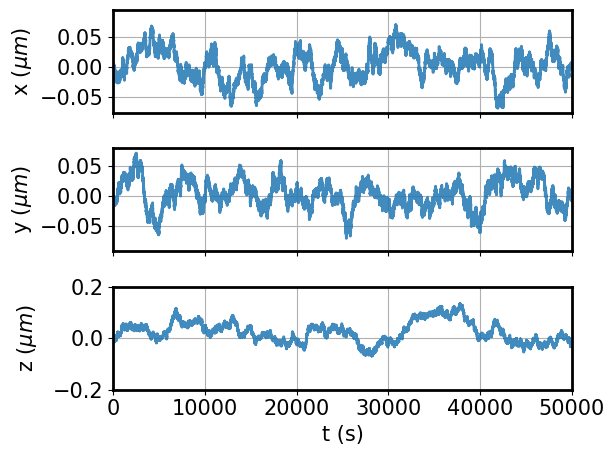

In [160]:
ax1 = plt.subplot(311)
#ax1.set_ylim([-0.08, 0.08])
ax1.set_ylabel(r'x $(\mu m)$')
ax1.plot(10**6*x, linewidth=2, alpha=0.85)
plt.tick_params('x', labelbottom=False)
plt.grid()


# share x only
ax2 = plt.subplot(312, sharex=ax1)
#ax2.set_ylim([-0.08,0.08])
ax2.set_ylabel(r'y $(\mu m)$')
ax2.plot(10**6*y, linewidth=2, alpha=0.85)

# make these tick labels invisible
plt.tick_params('x', labelbottom=False)
plt.ticklabel_format(style='sci')
plt.grid()


# share x and y
ax3 = plt.subplot(313, sharex=ax1)
ax3.set_ylim([-0.2, 0.2])
ax3.set_ylabel(r'z $(\mu m)$')
ax3.plot(10**6*z, linewidth=2, alpha=0.85)
plt.xlim(0, 50000.0)
ax3.yaxis.labelpad = 10
ax3.set_xlabel('t (s)')
plt.grid()
plt.savefig('../data/plots/traces_simulated.pdf', dpi=300)
plt.show()

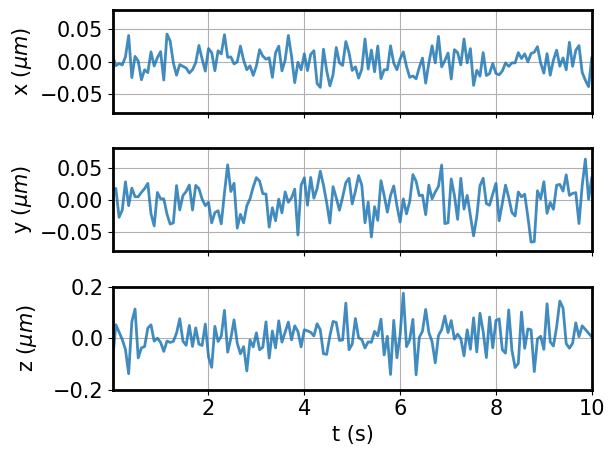

In [161]:
ax1 = plt.subplot(311)
ax1.set_ylim([-0.08, 0.08])
ax1.set_ylabel(r'x $(\mu m)$')
plt.plot(1/15*np.linspace(0, len(measures['y-um'].values)+1, len(measures['y-um'].values)), 10**6*measures['x-um'].values, linewidth=2, alpha=0.85)
plt.tick_params('x', labelbottom=False)
plt.grid()

ax2 = plt.subplot(312, sharex=ax1)
ax2.set_ylim([-0.08,0.08])
ax2.set_ylabel(r'y $(\mu m)$')
plt.plot(1/15*np.linspace(0, len(measures['y-um'].values)+1, len(measures['y-um'].values)), 10**6*measures['y-um'].values, linewidth=2, alpha=0.85)
plt.tick_params('x', labelbottom=False)
plt.ticklabel_format(style='sci')
plt.grid()

ax3 = plt.subplot(313, sharex=ax1)
ax3.set_ylim([-0.2, 0.2])
ax3.set_ylabel(r'z $(\mu m)$')
plt.plot(1/15*np.linspace(0, len(measures['y-um'].values)+1, len(measures['y-um'].values)), 10**6*conv_z*measures['z'].values, linewidth=2, alpha=0.85)
plt.xlim(0.01, 10.0)
ax3.yaxis.labelpad = 10
ax3.set_xlabel('t (s)')
plt.grid()
plt.savefig('../data/plots/traces_measured.pdf', dpi=300)
plt.show()

<a name='3'></a> 
### 3. Potential analysis

With the traces loaded is possible to find the distributions and as consequence coefficientes $k_\rho$, $k_z$ and $k_{z,\rho}$ of the potential. The `prob_distr` defines the function to be fitted.

In [332]:
def prob_distr(data, C, k1, k2, k3):
    beta = 1/(kb*T)
    r, z = data
    U = k1*np.power(r, 4) - k2*np.power(r,2)*np.power(z,2)+k3*np.power(z,2)
    return C*r*np.exp(-beta*U)

def create_3d_data(r, z, group_r, group_z):
    df = pd.DataFrame.from_dict({'r': r, 'z': z})
    def __convert_interval_to_float__(interval):
        splitted = str(interval)[1:-1].split(',')
        return 0.5*(float(splitted[0])+float(splitted[1]))
    rs, zs, counts = [], [], []
    groups = df.groupby([pd.cut(df.r, group_r),pd.cut(df.z, group_z)])
    grouped_df = groups.size().unstack()
    for i, row in grouped_df.iterrows():
        for index_i, index in enumerate(row.index):
            rs.append(__convert_interval_to_float__(row.name))
            zs.append(__convert_interval_to_float__(index))
            counts.append(row.iloc[index_i])
    rs = np.array(rs)
    zs = np.array(zs)
    counts = np.array(counts)
    return rs, zs, counts

In the next cell we are going to check the ratio between the root mean squared values of the $x$, $y$ and $r$ coordinates, showing the similarities between coordinates values.

In [333]:
ratio_x = np.sqrt(np.power(x,2).mean())/np.sqrt(np.power(measures['x-um'].values, 2).mean())
ratio_y = np.sqrt(np.power(y,2).mean())/np.sqrt(np.power(measures['y-um'].values, 2).mean())
ratio_r = np.sqrt(np.power(r,2).mean())/np.sqrt(np.power(measures['r'].values, 2).mean())
ratio_x, ratio_y, ratio_r

(1.1216881218904187, 0.8050497369089848, 0.9311424305752924)

Now, is possible to create a 3d distribution using the `create_3d_data` function, the counts returned by this function is the function value for the `curve_fit`, and `rs` and `zs` are the coordinates. In the next image the fit (left) and the distribution (right) are shown.

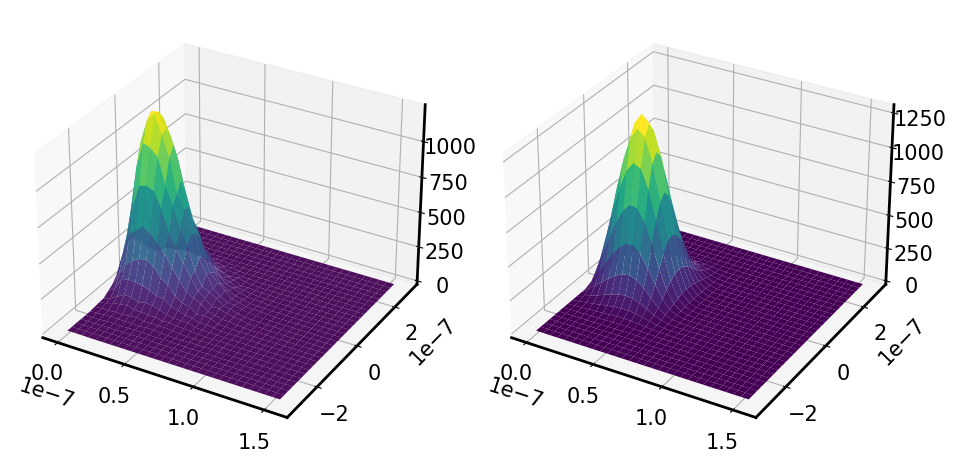

array([5.04708500e+10, 9.08727471e+08, 8.31001281e+07, 7.82112889e-07])

In [334]:
fig = plt.figure(figsize=plt.figaspect(0.5))
limits = np.array([9e10, 9e8+1e7*np.random.random(), 9.1e7, 3e-6])
rs, zs, counts = create_3d_data(measures['r'].values, measures['z-scaled'], np.linspace(0, 1.6e-7, 30), np.linspace(-3e-7, 3e-7, 30))

params, pcov, info, _, _ = curve_fit(prob_distr, (rs, zs), counts, bounds=([0, 1e6, 8e7+1e7*np.random.random(), 0], limits), full_output=True)

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
hist, xedges, yedges = np.histogram2d(measures['r'].values, measures['z-scaled'].values, bins=30, range=[[0, 1.6e-7], [-3e-7, 3e-7]])
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
zpos = 0
ax1.plot_surface(xpos, ypos, hist, alpha=0.95, cmap=matplotlib.cm.viridis)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
Z1 = prob_distr((xpos, ypos), params[0], params[1], params[2], params[3])
ax2.plot_surface(xpos, ypos, Z1, alpha=1.0, cmap=matplotlib.cm.viridis)
ax2.zaxis.set_rotate_label(False)
plt.show()

params

Now, to evaluate the quality of the fit, we are going to compute the function again, take only the points that are closer to the distribution. This is done to remove some of the null points that would pull the error metric to zero and would showed a biased result. Then the fit and distribution are normalized, and the MAE (mean averaged error) and RMSE (root mean squared error) are computed.

In [335]:
hist, xedges, yedges = np.histogram2d(measures['r'].values, measures['z-scaled'].values, bins=30, range=[[0, 1.6e-7], [-3e-7, 3e-7]])
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
Z1 = prob_distr((xpos, ypos), params[0], params[1], params[2], params[3])

In [336]:
filt_hist = hist[0:-10,4:-4].flatten()/hist.flatten().max()
filt_z1 = Z1[0:-10,4:-4].flatten()/hist.flatten().max()
np.abs(filt_hist-filt_z1).mean()

0.0542516781291267

In [337]:
np.sqrt(np.power(counts/counts.max() - prob_distr((rs, zs), *params)/counts.max(), 2).mean())

0.05167267521375948

In [338]:
np.abs(counts/counts.max() - prob_distr((rs, zs), *params)/counts.max()).mean()

0.0182710336252828

With the errors being small enough, we can use the coefficients returned by the fit to reconstruct the potential.

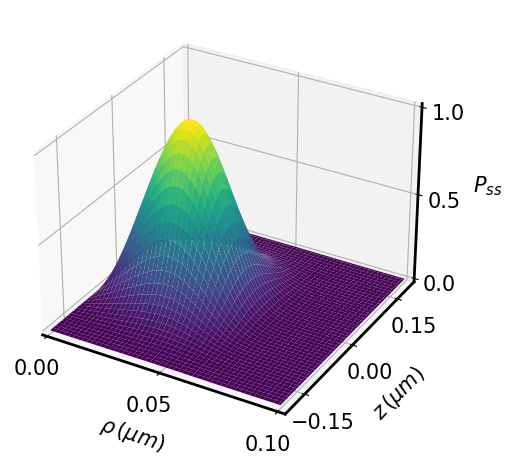

In [339]:
fig = plt.figure(figsize=plt.figaspect(0.5))
fig.set_figwidth(5)
fig.set_figheight(5)
ax = fig.add_subplot(1, 1, 1, projection='3d')
X1, Y1 = np.meshgrid(np.linspace(0, 1.0e-7, 100), np.linspace(-2e-7, 2e-7, 100))
Z1 = prob_distr((X1, Y1), params[0], params[1], params[2], params[3])
ax.plot_surface(10**6*X1, 10**6*Y1, Z1/Z1.max(), alpha=1.0, cmap=matplotlib.cm.viridis)
ax.set_ylim([-0.2, 0.2])
ax.set_xlim([0, 0.101])
ax.set_zlim([0, 1])
ax.set_xlabel(r'$\rho\,(\mu m)$')
ax.set_ylabel(r'$z\,(\mu m)$')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$P_{ss}$')
ax.set_xticks(np.arange(0, 0.11, 0.05))
ax.set_yticks(np.arange(-0.15, 0.16, 0.15))
ax.set_zticks(np.arange(0.0, 1.2, 0.5))
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 10
plt.savefig('../data/plots/potential_analysis_3d.pdf', dpi=300, bbox_inches = 'tight')
plt.show()

In [340]:
def U(rho, z, k1, k2, k3):
    return k1*np.power(rho, 4) - k2*np.power(rho, 2)*np.power(z,2) + k3*np.power(z,2)

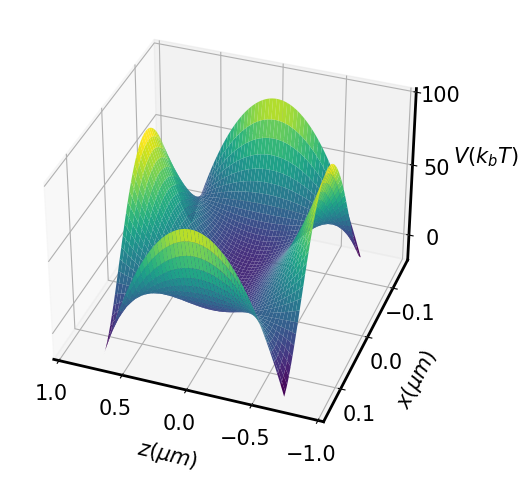

In [341]:
fig = plt.figure(figsize=plt.figaspect(0.5))
fig.set_figwidth(5)
fig.set_figheight(5)
k1, k2, k3 = params[1], params[2], params[3]
ax = fig.add_subplot(1, 1, 1, projection='3d')
X1, Y1 = np.meshgrid(np.linspace(-1.4e-7, 1.4e-7,200), np.linspace(-7e-7, 7e-7, 200))
ax.view_init(35, 110)
Z1 = prob_distr((X1, Y1), params[0], params[1], params[2], params[3])
ax.plot_surface(10**6*Y1, 10**6*X1, U(X1, Y1, k1, k2, k3)/(kb*T), alpha=1.0, cmap=matplotlib.cm.viridis, edgecolor='none')
ax.set_xlabel(r'$z(\mu m)$')
ax.set_ylabel(r'$x(\mu m)$')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$V(k_b T)$', rotation=0)
ax.set_xticks(np.arange(-1, 1.01, 0.5))
ax.set_yticks(np.arange(-0.10, 0.11, 0.1))
ax.set_zticks(np.arange(0, 100.1, 50))
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 15
plt.savefig('../data/plots/potential_3d.pdf', dpi=300, bbox_inches = 'tight')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.show()

/tmp/ipykernel_28774/2899667966.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax.pcolor(10**7*Z, 10**6*X, U(X, Z, k1, k2, k3)/(kb*T), cmap=matplotlib.cm.viridis, vmin=0, vmax=100)


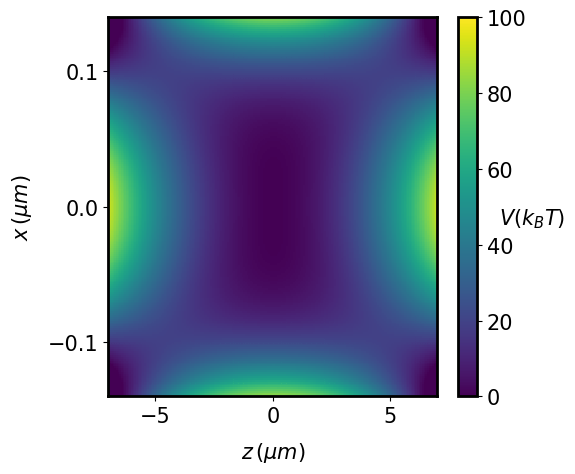

In [342]:
fig, ax = plt.subplots()
fig.set_figwidth(6)
fig.set_figheight(5)
X, Z = np.meshgrid(np.linspace(-1.4e-7, 1.4e-7,200), np.linspace(-7e-7, 7e-7, 200))
p = ax.pcolor(10**7*Z, 10**6*X, U(X, Z, k1, k2, k3)/(kb*T), cmap=matplotlib.cm.viridis, vmin=0, vmax=100)
cb = fig.colorbar(p, ax=ax)
cb.set_label(r'$V(k_B T)$', rotation=0)
ax.set_ylabel(r'$x\,(\mu m)$')
ax.set_xlabel(r'$z\,(\mu m)$')
ax.set_yticks(np.arange(-0.1, 0.11, 0.1))
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
plt.savefig('../data/plots/potential_colormap.png', dpi=300)
plt.show()